# TODO: Needs massive cleanup, contains random experiments with code and library

In [88]:
from datasets import load_dataset
import numpy as np
from transformers import DistilBertTokenizerFast, AutoModel, Trainer, TrainingArguments
import seaborn as sns
from dataclasses import dataclass
from typing import List, Union, Dict
import torch
from torch.utils.data import DataLoader
import multiprocessing

In [2]:
hdfs1_dataset = load_dataset('text', data_files='../data/raw/HDFS1/HDFS.log', split='train')

Using custom data configuration default-f7d20bad4b8d075b
Reusing dataset text (/home/cernypro/.cache/huggingface/datasets/text/default-f7d20bad4b8d075b/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691)


In [3]:
def remove_timestamp(example):
    # need to find third occurence of a space and slice the string after it
    # using a very non robust silly solution
    s = example['text']
    example['text'] = s[s.find(' ', s.find(' ', s.find(' ')+1)+1)+1:]
    return example

cleaned_dataset = hdfs1_dataset.map(remove_timestamp)

Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-f7d20bad4b8d075b/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-3f531662155381a4.arrow


In [4]:
len(cleaned_dataset)

11175629

In [5]:
pretrained_model_name = "distilbert-base-cased"
tokenizer = DistilBertTokenizerFast.from_pretrained(pretrained_model_name)

In [66]:
small_cleaned_dataset = cleaned_dataset.select(range(200000))

In [67]:
def tokenize_dontpad_dataset(examples, tokenizer):
    return tokenizer(examples['text'], truncation=True, return_special_tokens_mask=True)
# tokenized_unpadded_dataset = cleaned_dataset.map(tokenize_dontpad_dataset, fn_kwargs={'tokenizer': tokenizer}, batched=True, batch_size=1000, remove_columns=['text'])

In [68]:
def tokenize_no_special_tokens(examples, tokenizer):
    return {'tokens': tokenizer(examples['text'], add_special_tokens=False, truncation=True, return_attention_mask=False)['input_ids']}
small_tokenized = small_cleaned_dataset.map(tokenize_no_special_tokens, fn_kwargs={'tokenizer': tokenizer}, batched=True, batch_size=1000)

In [69]:
def chunkify(examples):
    return {"chunk": [examples['tokens']]}
chunked = small_tokenized.map(chunkify, batched=True, batch_size=10, drop_last_batch=True, remove_columns=small_tokenized.column_names, num_proc=4)

In [70]:
chunked

Dataset({
    features: ['chunk'],
    num_rows: 20000
})

In [71]:
@dataclass
class DataCollatorForInverseClozeTaskOrig:
    """
    Data Collator to be used with datasets containing contexts (List of senteces, where sentence is a list of tokens, e.g a context is a List of Lists of ints)
    It randomly selects a sentence from each context to serve as a target, and flattens the contexts (with the target sentence randomly removed) into a single sentence to serve as a flat context
    If using huggingface datasets, expects a column named 'chunk'
    NOTE: This collator is quite slow, if the dataset is really large, consider pre-collating it in advance and saving it, so that the collator can then be as simple as possible
        (example of how slow it is, when resuming almost finished training on a dataset of 800k contexts (each containing 10 lines, eg 8M lines in total)
        using batches of size 64, resuming training took over 5 hours on 4 cores, because all the intermediate batches were created by the dataloader and collated by this collater
        until the Trainer (huggingface) reached the saved step in the checkpoint)
    """
    remove_target_from_context_probability: float = 0.9
    target_max_seq:int = 512
    context_max_seq:int = 512
    start_token:int = 101 # [CLS]
    sep_token:int = 102 # [SEP]
    pad_token:int = 0
        
    def _make_mask(self, padded_batch):
        return (padded_batch != self.pad_token).astype(np.uint8)
        
    def _pad_truncate_add_special_tokens(self, batch: List[List[int]], max_len): 
        sequence_lengths = np.array([min(max_len-2, len(seq)) for seq in batch])
        batch_max_len = sequence_lengths.max()
        padded_batch = np.full(shape=(len(batch), batch_max_len+2), fill_value=self.pad_token, dtype=np.int64)
        padded_batch[:, 0] = self.start_token
        for seq_idx, seq in enumerate(batch):
            padded_batch[seq_idx, 1:sequence_lengths[seq_idx]+1] = seq[:sequence_lengths[seq_idx]]
            padded_batch[seq_idx, sequence_lengths[seq_idx]+1] = self.sep_token
        mask = self._make_mask(padded_batch)
        return torch.from_numpy(padded_batch), torch.from_numpy(mask)
    
    def _create_target_and_flat_contexts_from_contexts(self, contexts: List[List[List[int]]]):
        # TODO: add sep_token between each sentence when flattening context?
        target_sentence_idxs = [torch.randint(low=0, high=len(context), size=(1,)).item() for context in contexts]
        remove_target = [torch.rand(size=(1,)).item() < self.remove_target_from_context_probability for _ in target_sentence_idxs]
        target_sentences = [context[i] for (i, context) in zip(target_sentence_idxs, contexts)]
        processed_contexts = [context[:target_idx] + context[target_idx + remove:] for (target_idx, remove, context) in zip(target_sentence_idxs, remove_target, contexts)]
        flattened_contexts = [[token for sentence in context for token in sentence] for context in processed_contexts]
        return target_sentences, flattened_contexts
             
    def __call__(self, contexts: List[Union[List[List[int]], Dict[str, List[List[int]]]]]):
        if isinstance(contexts[0], dict):
            contexts = [context_dict['chunk'] for context_dict in contexts]
        target_sentences, flattened_contexts = self._create_target_and_flat_contexts_from_contexts(contexts)
        correct_class = torch.tensor(list(range(len(target_sentences))), dtype=torch.int64)
        padded_target_batch, padded_target_mask = self._pad_truncate_add_special_tokens(target_sentences, self.target_max_seq)
        padded_context_batch, padded_context_mask = self._pad_truncate_add_special_tokens(flattened_contexts, self.context_max_seq)
        return {'target': padded_target_batch,
                'target_mask': padded_target_mask,
                'context': padded_context_batch,
                'context_mask': padded_context_mask,
                'correct_class': correct_class}

In [72]:
@dataclass
class DataCollatorForInverseClozeTask:
    """
    Data Collator to be used with datasets containing contexts (List of senteces, where sentence is a list of tokens, e.g a context is a List of Lists of ints)
    It randomly selects a sentence from each context to serve as a target, and flattens the contexts (with the target sentence randomly removed) into a single sentence to serve as a flat context
    If using huggingface datasets, expects a column named 'chunk'
    NOTE: This collator is quite slow, if the dataset is really large, consider pre-collating it in advance and saving it, so that the collator can then be as simple as possible
        (example of how slow it is, when resuming almost finished training on a dataset of 800k contexts (each containing 10 lines, eg 8M lines in total)
        using batches of size 64, resuming training took over 5 hours on 4 cores, because all the intermediate batches were created by the dataloader and collated by this collater
        until the Trainer (huggingface) reached the saved step in the checkpoint)
    """
    remove_target_from_context_probability: float = 0.9
    target_max_seq:int = 512
    context_max_seq:int = 512
    start_token:int = 101 # [CLS]
    sep_token:int = 102 # [SEP]
    pad_token:int = 0
    all_contexts_same_length: bool = False
        
    def _make_mask(self, padded_batch):
        return (padded_batch != self.pad_token).astype(np.uint8)
        
    def _pad_truncate_add_special_tokens(self, batch: List[List[int]], max_len): 
        sequence_lengths = np.array([min(max_len-2, len(seq)) for seq in batch])
        batch_max_len = sequence_lengths.max()
        padded_batch = np.full(shape=(len(batch), batch_max_len+2), fill_value=self.pad_token, dtype=np.int64)
        padded_batch[:, 0] = self.start_token
        for seq_idx, seq in enumerate(batch):
            padded_batch[seq_idx, 1:sequence_lengths[seq_idx]+1] = seq[:sequence_lengths[seq_idx]]
            padded_batch[seq_idx, sequence_lengths[seq_idx]+1] = self.sep_token
        mask = self._make_mask(padded_batch)
        return torch.from_numpy(padded_batch), torch.from_numpy(mask)
    
    def _get_target_sentence_idxs(self, contexts):
        if self.all_contexts_same_length:
            all_contexts_len = len(contexts[0])
            return torch.randint(low=0, high=all_contexts_len, size=(len(contexts),))
        else:
            return [torch.randint(low=0, high=len(context), size=(1,)).item() for context in contexts]
    
    def _create_target_and_flat_contexts_from_contexts(self, contexts: List[List[List[int]]]):
        # TODO: add sep_token between each sentence when flattening context?
        target_sentence_idxs = self._get_target_sentence_idxs(contexts)
        remove_target = torch.bernoulli(torch.full(size=(len(target_sentence_idxs),), fill_value=self.remove_target_from_context_probability)).to(torch.bool)
        target_sentences = [context[i] for (i, context) in zip(target_sentence_idxs, contexts)]
        processed_contexts = [context[:target_idx] + context[target_idx + remove:] for (target_idx, remove, context) in zip(target_sentence_idxs, remove_target, contexts)]
        flattened_contexts = [[token for sentence in context for token in sentence] for context in processed_contexts]
        return target_sentences, flattened_contexts
             
    def __call__(self, contexts: List[Union[List[List[int]], Dict[str, List[List[int]]]]]):
        if isinstance(contexts[0], dict):
            contexts = [context_dict['chunk'] for context_dict in contexts]
        target_sentences, flattened_contexts = self._create_target_and_flat_contexts_from_contexts(contexts)
        correct_class = torch.arange(len(target_sentences), dtype=torch.int64)
        padded_target_batch, padded_target_mask = self._pad_truncate_add_special_tokens(target_sentences, self.target_max_seq)
        padded_context_batch, padded_context_mask = self._pad_truncate_add_special_tokens(flattened_contexts, self.context_max_seq)
        return {'target': padded_target_batch,
                'target_mask': padded_target_mask,
                'context': padded_context_batch,
                'context_mask': padded_context_mask,
                'correct_class': correct_class}
    

In [84]:
torch.manual_seed(43)
new_col = DataCollatorForInverseClozeTask(all_contexts_same_length=True)
old_col = DataCollatorForInverseClozeTaskOrig()
new_dataloader = DataLoader(chunked, batch_size=16, collate_fn=new_col)
old_dataloader = DataLoader(chunked, batch_size=16, collate_fn=old_col)

In [85]:
%%timeit
for _ in new_dataloader:
    pass

13 s ± 52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
torch.manual_seed(43)

In [87]:
%%timeit
for _ in old_dataloader:
    pass

12.8 s ± 77.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
def identity_printer(examples):
    print(multiprocessing.current_process())
    return examples

chunked.map(identity_printer, num_proc=4, batched=True, batch_size=2000)

<_MainProcess(MainProcess, started)>


Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-f7d20bad4b8d075b/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-d994e89e065a9913.arrow
Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-f7d20bad4b8d075b/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-01988c2bed2b0797.arrow
Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-f7d20bad4b8d075b/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-0ebb302ab7390d01.arrow
Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-f7d20bad4b8d075b/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-d5cfbbb7e2fa38de.arrow


Dataset({
    features: ['chunk'],
    num_rows: 20000
})

In [51]:
torch.manual_seed(43)
torch.randint(low=0, high=10, size=(5,))

tensor([8, 8, 5, 7, 5])

In [40]:
torch.manual_seed(43)
[int(torch.rand(size=(1,)).item() < 0.9) for _ in range(5)]

[1, 1, 0, 1, 1]

In [50]:
torch.manual_seed(43)
torch.bernoulli(torch.full((5,), 0.9)).to(torch.bool)[0]

tensor(True)

In [26]:
torch.arange(5, dtype=torch.int64)

tensor([0, 1, 2, 3, 4])

In [15]:
class ClsEncoderTower(torch.nn.Module):
    def __init__(self, pretrained_model_name_or_path, output_encode_dimension=512):
        super(ClsEncoderTower, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name_or_path)
        self.linear = torch.nn.Linear(self.bert.config.dim, output_encode_dimension) # self.bert.config.dim most likely 768
        
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_embedding = bert_output[0][:, 0]
        cls_encoding = self.linear(cls_token_embedding)
        return cls_encoding
        
    

In [16]:
class OneTowerICT(torch.nn.Module):
    def __init__(self, pretrained_model_name_or_path, output_encode_dimension=512):
        super(OneTowerICT, self).__init__()
        self.tower = ClsEncoderTower(pretrained_model_name_or_path, output_encode_dimension)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    def forward(self, target, target_mask, context, context_mask, correct_class):
        target_cls_encode = self.tower(input_ids=target, attention_mask=target_mask)
        context_cls_encode = self.tower(input_ids=context, attention_mask=context_mask)
        
        logits = torch.matmul(target_cls_encode, context_cls_encode.transpose(-2, -1))
        loss = self.loss_fn(logits, correct_class)
        return loss, target_cls_encode, context_cls_encode

In [19]:
class TwoTowerICT(torch.nn.Module):
    def __init__(self, target_tower_pretrained_model_name_or_path, context_tower_pretrained_model_name_or_path=None, output_encode_dimension=512):
        super(TwoTowerICT, self).__init__()
        assert target_tower_pretrained_model_name_or_path is not None, "Target tower pretrained model must me specified!"
        if context_tower_pretrained_model_name_or_path is None:
            context_tower_pretrained_model_name_or_path = target_tower_pretrained_model_name_or_path
        self.target_encoder = ClsEncoderTower(target_tower_pretrained_model_name_or_path, output_encode_dimension)
        self.context_encoder = ClsEncoderTower(context_tower_pretrained_model_name_or_path, output_encode_dimension)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, target, target_mask, context, context_mask, correct_class):
        target_cls_encode = self.target_encoder(input_ids=target, attention_mask=target_mask)
        context_cls_encode = self.context_encoder(input_ids=context, attention_mask=context_mask)
        
        logits = torch.matmul(target_cls_encode, context_cls_encode.transpose(-2, -1))
        loss = self.loss_fn(logits, correct_class)
        return loss, target_cls_encode, context_cls_encode
        

In [20]:
model = TwoTowerICT(pretrained_model_name)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
SEED=0
RUN_NAME="ICT DEBUG - Two Towers 1"
train_test_dataset = chunked.train_test_split(test_size=256, shuffle=True, seed=SEED)

Loading cached split indices for dataset at /home/cernypro/.cache/huggingface/datasets/text/default-f7d20bad4b8d075b/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-5e8ebae16cf9f389.arrow and /home/cernypro/.cache/huggingface/datasets/text/default-f7d20bad4b8d075b/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-42be9c3ea68c8082.arrow


In [24]:
data_collator = DataCollatorForInverseClozeTask()

In [25]:
training_args = TrainingArguments(output_dir=f"../models/{RUN_NAME.replace(' ', '_')}",
                                      num_train_epochs=5,
                                      per_device_eval_batch_size=64, 
                                      per_device_train_batch_size=64,
                                      warmup_steps=10,                # number of warmup steps for learning rate scheduler
                                      weight_decay=0.01,               # strength of weight decay
                                      logging_dir='../logs',            # directory for storing logs
                                      logging_steps=10,
                                      logging_first_step=True,
                                      eval_steps=20,
                                      evaluation_strategy='steps',
                                      prediction_loss_only=True,
                                      save_steps=100,
                                      save_total_limit=15,
                                      label_names=['target', 'context'],
                                      seed=SEED,
                                      run_name=RUN_NAME,
                                      remove_unused_columns=False)

trainer = Trainer(model=model,
                      args=training_args,
                      data_collator=data_collator,
                      train_dataset=train_test_dataset['train'],
                      eval_dataset=train_test_dataset['test']
                      )

In [26]:
torch.manual_seed(SEED)

In [27]:
trainer.train()

wandb: Currently logged in as: prokopcerny (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
20,3.525900,3.474082,1.434300,178.489000
40,3.365100,3.346828,1.448000,176.791000
60,3.163100,3.354304,1.451100,176.416000
80,3.346800,3.367447,1.463600,174.906000
100,3.290700,3.209431,1.462000,175.098000
120,3.101400,3.205889,1.468300,174.349000
140,3.123900,3.287006,1.476700,173.360000


TrainOutput(global_step=140, training_loss=3.3440962553024294, metrics={'train_runtime': 177.2968, 'train_samples_per_second': 0.79, 'total_flos': 0, 'epoch': 5.0})

In [19]:
trainer.save_model()

In [34]:
trainer.evaluate(train_test_dataset['train'])

wandb: WARNING Step must only increase in log calls.  Step 0 < 246; dropping {'eval/loss': 4.083710193634033, 'eval/runtime': 7.9367, 'eval/samples_per_second': 193.783}.


{'eval_loss': 4.083710193634033,
 'eval_runtime': 7.9367,
 'eval_samples_per_second': 193.783}

In [6]:
def get_lenghts(example):
    return {'length': len(example['input_ids'])}
lenghts = tokenized_unpadded_dataset.map(get_lenghts, remove_columns=tokenized_unpadded_dataset.column_names)

Loading cached processed dataset at /home/cernypro/.cache/huggingface/datasets/text/default-3571b23bb2152210/0.0.0/44d63bd03e7e554f16131765a251f2d8333a5fe8a73f6ea3de012dbc49443691/cache-5b3337e81c3dc2cb.arrow


In [15]:
mean = np.mean(lenghts['length'])
mean

60.6453264509765

<AxesSubplot:ylabel='Density'>

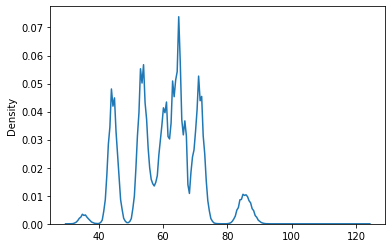

In [8]:
sns.kdeplot(lenghts['length'])